Author: Rashad Haddad   
Description: This notebook provides a response to the following interview question:    

```
This question will be centered around one of our notable customers, Lido. Your first task is to identify key performance indicators (KPIs) for Lido, keeping them accurate and relevant. 

Next, we'll begin a technical challenge by assuming organic volume growth on centralized exchanges is one of their essential KPIs. Use Jupyter or DeepNote to stitch data from various sources (such as Bybit, Huobi, Gate, MEXC, OKX, Binance, Coinbase, and/or Kraken) to formulate some valuable insight, along with some visualizations. Afterward, please construct a concise report with 1-2 of these insights.
```

## (1) KPI's for LIDO

Lido is a platform for liquid staking of ethereum. Users can deposit their ethereum to the contract and in return received stETH, which is a ERC-20 token that can be transfered, sold, and used for a variety of applications in DeFi. 

KPIs for LIDO should focus on measuring growth, performance of the token and services, profitability, and risks to the users or the platform.  

### Possible growth KPI's

#### Total Value Locked (TVL):

Given staking is at the core of Lido's operation, tracking the how much Ether is deposited into the Lido smart contract is an important measure of the demand for Lido's services. TVL can also be used to compare how much demand Lido is attracting relative to its competitors such as Rocket Pool.  

#### Number of Active Stakers

How many unique Ethereum addresses are depositing to Lido? Increases in this amount could suggest growth in demand for Lido

#### Average/Median Staked Amount per user

How much is the typical Lido user staking, what does the distribution look like? What is the mean, 25/50/75 percentiles? What is the growth in users within these segments? This might tell us something about the typical person that Lido attracts, and where to focus marketing and growth initiatives

### Possible performance KPIs

#### Staking rewards rate

Lido isn't the only liquid staking service available. How does the APY offered by Lido compare to competitors?

#### Overhead costs per ether deposited

How much does Lido need to spend on running all of its operating activities per ether on deposit? Can we identify areas where costs could be reduced? Could these cost reductions be passed to users in the form of a higher APY?

### Possible risk KPIs

#### Slashing Incidents

How much money is lost per month/quarter/year on slashing? How about per node operator of the Lido network? Are some node operators part of the Lido network seeing more slashing incidents than others? Should some of these node operators be asked to stop participating? Likewise, which node operators are performing the best, and can we replicate what makes them successful accross node operators that are part of the Lido network?

#### Regulatory exposure

Using data available on or off chain, can we indentify the volume of users/assets on deposit that are exposed to certain geopolitical regions and regimes that might not be crypto friendly? What risks might changes in regulatory frameworks in these regions have on Lido based on it's exposure, if any, to these regions? Should Lido have to change in business policies as a result? How might this impact the bottom line?

### (2) Measuring organic growth on centralized exchanges

Given stETH is a tradeable ERC-20 token, one measure of growth may be to measure how much stETH is being brought onto centralized exchanges that list the token. As not everyone is DeFi friendly, or wants to deal with issues such as self custody, paying gas fees, and learning how to use L2's, measuring how much demand there is for stETH on centralized exchanges may be a useful KPI to measure mainstream/retail demand for stETH

#### How can we measure this?

Most CEX's have addresses on-chain associated with the exchange, and are labeled by etherscan. Using the following, link we can look at top holders of stETH.  

https://etherscan.io/token/0xae7ab96520de3a18e5e111b5eaab095312d7fe84#balances

**For this exercise I have chosen to work with the bybit hot-wallet address as it holds a large number of stETH, providing a reasonable proxy to measure organic growth, and simpflies analysis for the rest of the report**

The address associated with Bybit's hotwallet is 0xf89d7b9c864f589bbF53a82105107622B35EaA40, and as of writing it holds ~ 22,370 stETH.

We can use the graph protocol to figure out how much stETH is flowing into/out of this address

**I use the following subgraph from the hosted service**  
```https://thegraph.com/hosted-service/subgraph/lidofinance/lido```

Below we import dependencies and bring in some helper functions to collect information about addresses that have either sent value to OR received value from Bybit HotWallet.

In [1]:
import datetime
import requests
import pandas as pd

In [2]:
bybit_addr = "0xf89d7b9c864f589bbF53a82105107622B35EaA40"

In [3]:
def lido_to(addr: str, first: int = 1000, skip: int = 0) -> str:
    """Create query to get transactions headed to from an addr via lido."""
    return ("""{
                lidoTransfers(first: %s, skip: %s, where : {to : "%s"}) {
                    from
                    to
                    value
                    blockTime
                    transactionHash
                }
                }""" % (first, skip, addr)).replace("\n","")

def lido_from(addr: str, first: int = 1000, skip: int = 0) -> str:
    """Create query to get transactions headed from an addr via lido."""
    return ("""{
                lidoTransfers(first: %s, skip: %s, where : {from : "%s"}) {
                    from
                    to
                    value
                    blockTime
                    transactionHash
                }
                }""" % (first, skip, addr)).replace("\n","")

In [4]:
def get_lido_data(addr: str, max_skips: int = 20, mode = "from") -> pd.DataFrame:
    """Fetch historical data from lido hosted subgraph.

    Args:
        addr: (str): Address of the account receiving or sending stETH.
        max_skips (str): Max number of paginations to try. Defaults to 10.

    Returns:
        (DataFrame): Historical Dataframe of prices.
    """

    # to get all the historical data, we need to paginate.
    if mode not in ["from", "to"]:
        raise Exception("mode must be either 'from' or 'to'")
    
    skips = 0

    responses = {"data" : []}

    while skips < max_skips:
        # get the query
        query_func = lido_from if mode == "from" else lido_to
        query = query_func(
                        addr=addr,
                        first=1000,
                        skip=skips
                        )
        
        # make a request for the data
        request = requests.post("https://api.thegraph.com/subgraphs/name/lidofinance/lido",
                                '',
                                json={'query': query})

        if request.status_code == 200:
            # add response
            try:
                responses["data"].append(request.json()["data"]["lidoTransfers"])
            except:
               continue
        else:
            print('Query failed. return code is {}.      {}'.format(request.status_code, query))
            return responses

        # increment skips
        skips += 1
    
    # return responses
    return responses

Let's fetch the data. let's fetch up to 50 skips.

In [5]:
to_bybit_data = get_lido_data(
    max_skips=50,
    mode="to",
    addr=bybit_addr
)

from_bybit_data = get_lido_data(
    max_skips=50,
    mode="from",
    addr=bybit_addr
)

From these, lets normalize by blockTime.

In [6]:
def make_value_df(json_dat: dict) -> pd.DataFrame:

    tx_hashs = set()
    token_values = []
    time_stamps = []

    for dat_list in json_dat:
        for dat_dict in dat_list:
            try:
                tx_hash = dat_dict["transactionHash"]
                if tx_hash in tx_hashs:
                    continue  # avoid duplicate txs
                tx_hashs.add(tx_hash)

                value = float(dat_dict["value"]) / 10**18
                dt = datetime.datetime.fromtimestamp(int(dat_dict["blockTime"]))
            except:
                continue

            token_values.append(value)
            time_stamps.append(dt)

    res = pd.DataFrame({"total_token_value" : token_values}, index=pd.to_datetime(time_stamps)).sort_index(ascending=False)
    return res.groupby(res.index).sum()


In [7]:
to_bybit_df   = make_value_df( to_bybit_data['data'] )
from_bybit_df = make_value_df( from_bybit_data['data'] )

In [8]:
to_bybit_df.head()

,total_token_value
2021-11-16 02:15:57,0.041379
2021-12-25 02:00:38,10.000000
2022-01-16 04:17:31,1.004098
2022-01-16 15:03:39,1.000000
2022-01-19 03:43:35,1.017100


In [9]:
from_bybit_df.head()

,total_token_value
2021-11-16 02:24:43,0.034679
2022-06-26 15:38:35,35.500000
2022-07-29 22:12:24,10.695690
2022-08-07 10:31:56,8.731147
2022-08-10 09:41:24,100.000000


Let's align these together.

In [10]:
to_bybit_df.rename(columns = {'total_token_value' : 'to_bybit'}, inplace=True)
from_bybit_df.rename(columns = {'total_token_value' : 'from_bybit'}, inplace=True)
bybit_df = to_bybit_df.join(from_bybit_df, how='outer')  # outer join to keep all dates

In [11]:
bybit_df.head()

,to_bybit,from_bybit
2021-11-16 02:15:57,0.041379,NaN
2021-11-16 02:24:43,NaN,0.034679
2021-12-25 02:00:38,10.000000,NaN
2022-01-16 04:17:31,1.004098,NaN
2022-01-16 15:03:39,1.000000,NaN


Let's figure out cummulative flows.

In [12]:
bybit_df.fillna(0, inplace=True)

In [13]:
bybit_df["net_flow"] = bybit_df["to_bybit"] - bybit_df["from_bybit"]
bybit_df["cum_flow"] = bybit_df["net_flow"].cumsum()

Because the data only goes to 2021-11-16 for the data, and we know stETH launched in December 2020, let's add the difference to the start of the cum flow so it ties to the current balance

In [14]:
current_bal = 22370  # roughly as of 2023-07-30
diff_at_end = current_bal - bybit_df.iloc[-1]["cum_flow"]
bybit_df["cum_flow"] += diff_at_end

In [15]:
bybit_df

,to_bybit,from_bybit,net_flow,cum_flow
2021-11-16 02:15:57,0.041379,0.000000,0.041379,12369.257251
2021-11-16 02:24:43,0.000000,0.034679,-0.034679,12369.222573
2021-12-25 02:00:38,10.000000,0.000000,10.000000,12379.222573
2022-01-16 04:17:31,1.004098,0.000000,1.004098,12380.226671
2022-01-16 15:03:39,1.000000,0.000000,1.000000,12381.226671
...,...,...,...,...
2023-07-28 09:43:59,1.065871,0.000000,1.065871,22412.687348
2023-07-28 18:15:35,0.000000,3.148899,-3.148899,22409.538449
2023-07-29 13:59:35,0.000000,2.647872,-2.647872,22406.890577
2023-07-29 18:17:35,0.000000,36.082475,-36.082475,22370.808101


#### Growth in bybit holdings of stETH since 2021-11-16

In [16]:
import matplotlib.pyplot as plt

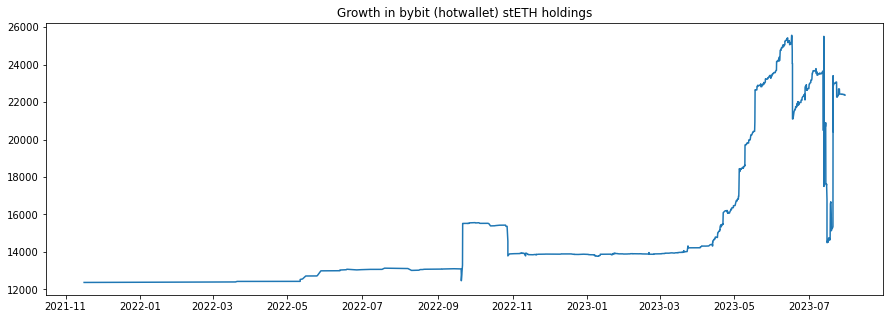

In [17]:
plt.figure(figsize=(15,5))
plt.plot(bybit_df.index, bybit_df.cum_flow)
plt.title("Growth in bybit (hotwallet) stETH holdings")
plt.show()

There appears to be some large changes in the number of staked ETH in bybit, this may be caused by either internal transfers or large market participants trading in and out of bybit. Generally, bybit has seen steady growth in the amount of stETH moved into the exchange, with a large increase post staking withdraws late Q1 '23. 

#### How much of this growth is coming from unique users?

We can look at how many unique addresses have sent value or withdrawn value from bybit over time. This may be an indication of how much of the growth in the balance on Bybit is driven by (potentially) new users, versus existing holders.

In [18]:
from_addrs_cnts = {}
to_addrs_cnts = {}

from_addrs_obs = set()
to_addrs_obs = set()

for json_dict in to_bybit_data['data'][0]:
    addr = json_dict['from']
    if addr not in from_addrs_obs:
        dt = datetime.datetime.fromtimestamp(int(json_dict["blockTime"]))
        from_addrs_cnts[dt] = from_addrs_cnts.get(dt, 0) + 1
        from_addrs_obs.add(addr)

for json_dict in from_bybit_data['data'][0]:
    addr = json_dict['to']
    if addr not in from_addrs_obs:
        dt = datetime.datetime.fromtimestamp(int(json_dict["blockTime"]))
        to_addrs_cnts[dt] = to_addrs_cnts.get(dt,0) + 1
        to_addrs_obs.add(addr)

from_addrs_cnts = pd.DataFrame(pd.Series(from_addrs_cnts), columns=["from"])
to_addrs_cnts = pd.DataFrame(pd.Series(to_addrs_cnts), columns=["to"])

addrs_cnts = from_addrs_cnts.join(to_addrs_cnts, how='outer').fillna(0).groupby(level=0).sum().cumsum()
addrs_cnts.loc[:,"Cum_Total"] = addrs_cnts.sum(axis=1)

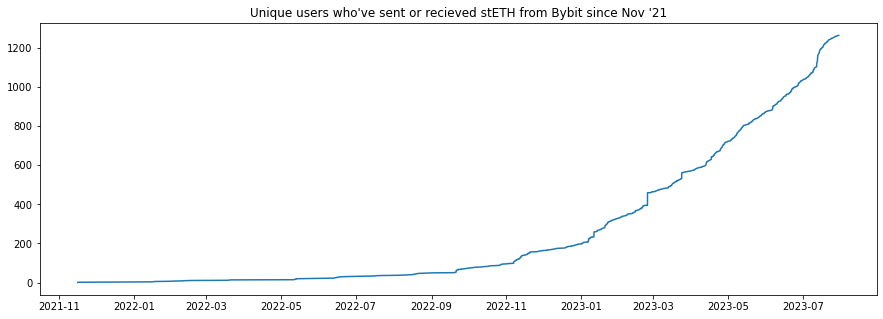

In [19]:
plt.figure(figsize=(15,5))
plt.plot(addrs_cnts.index, addrs_cnts.Cum_Total)
plt.title("Unique users who've sent or recieved stETH from Bybit since Nov '21")
plt.show()

This shows a pretty steady increase, we can also look at this on a log scale to judge how steady the growth has been.

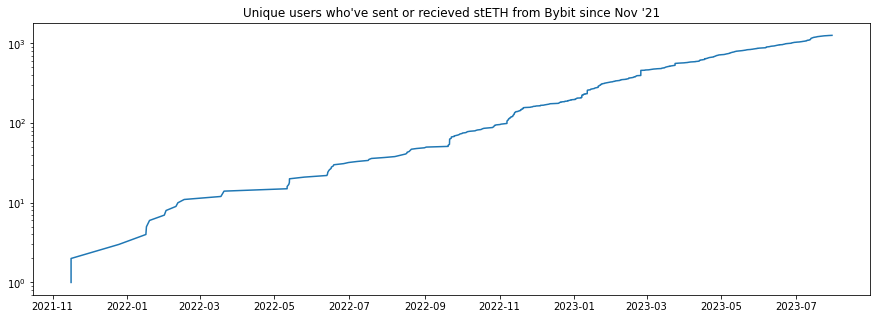

In [20]:
plt.figure(figsize=(15,5))
plt.plot(addrs_cnts.index, addrs_cnts.Cum_Total)
plt.title("Unique users who've sent or recieved stETH from Bybit since Nov '21")
plt.yscale('log')
plt.show()

This is fairly linear on a log scale which implies a pretty steady growth rate in terms of the number of unique addresses. We can back out this growth rate with a bit of algebra...

Note since we don't know from the subgraph the number of unique users that have interacted with stETH via Bybit as of Nov '21 we need to approximate that number at the start of the period. We can use the approximation of the balance at the start of the period from earlier with the ending value to the average amount of stETH per user to come up with a reasonable approximation.

In [21]:
import numpy as np

avg_at_end = bybit_df.cum_flow.iloc[-1] / addrs_cnts.Cum_Total.iloc[-1]
starting_value_approx = bybit_df.cum_flow.iloc[0] / avg_at_end  # approx number of users to make up this quantity...
annual_growth_rate = np.log(addrs_cnts.iloc[-1].Cum_Total / starting_value_approx) / (addrs_cnts.index[-1] - addrs_cnts.index[0]).days * 365
print("Annual growth rate in stETH user count implied by Bybit: {0}%".format(round(annual_growth_rate*100,2)))

Annual growth rate in stETH user count implied by Bybit: 34.83%


We estimate about a 34.83% annual growth rate in the number of unique addresses. We note that as individual users may have multiple addresses associated with a unique root phrase, that the real growth rate is likely lower than the number reported here. We also note that this is an estimate based on a single source of data, and while byBit is certainly a large holder of stETH, it is not the majority.

**What is the typical balance held by each unique user interacting with byBit?**

for each unique address that has interacted with bybit from the Lido contract, we can make a query to get it's current balance. For accounts with some amount more than some trivial amount (say 0.01 stETH), what is the mean, median, average, and interquartile range?

In [22]:
import json
stETH_abi = json.loads(open('stETH_abi.txt','r').read())  # from https://etherscan.io/address/0x17144556fd3424edc8fc8a4c940b2d04936d17eb#code:~:text=Submit%20Audit%20Here-,Contract%20ABI,-Export%20ABI

In [23]:
# Note I have removed my API key from this notebook, you should copy paste your own API key here inside of the string
YOUR_INFURA_API = "<YOUR INFURA API KEY HERE>"

In [24]:
import web3


def get_stETH_bal(addr: str):

    # setup infura endpoint
    web3_ep = web3.Web3(web3.Web3.HTTPProvider(YOUR_INFURA_API))

    # Get the Lido smart contract address
    lido_contract_address = "0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84"

    # Create a contract instance for the Lido smart contract
    lido_contract = web3_ep.eth.contract(address=lido_contract_address, abi=stETH_abi)

    # Get the balance of the address
    return lido_contract.functions.balanceOf(addr).call() / 10**18

In [25]:
# balance of Lido: All of bybit hotwallet as a test
get_stETH_bal(bybit_addr)

22370.54068356638

In [26]:
bybit_user_stETH_bals = {}

for addr in to_addrs_obs.union(from_addrs_obs):
    bybit_user_stETH_bals[addr] = bybit_user_stETH_bals.get(addr,0) + get_stETH_bal(web3.Web3.to_checksum_address(addr.lower()))

In [27]:
bybit_user_stETH_bals_srs = pd.Series(bybit_user_stETH_bals)
dust = 0.01 # anything less than this we will consider a trivial amount
bybit_user_stETH_bals_filtered = bybit_user_stETH_bals_srs[bybit_user_stETH_bals_srs > dust]
bybit_user_stETH_bals_filtered.describe()

count     144.000000
mean      102.326565
std       730.749054
min         0.010139
25%         0.083521
50%         1.999150
75%        11.274974
max      8563.239258
dtype: float64

Filtering for address that hold at least 0.01 stETH, the typical balance on chain for a stETH holder based on Bybit users is about 1.99 with the 25th percentile at ~0.08 and the 75th percentile at ~11.27 stETH. This is a pretty large dispertion, but given the current market price of ETH is roughly $1.86k as of writing, this suggests the typical stETH holder has under $22k USD worth of stETH. This seems about right for retail investors.

We note that the distribution is highly right skewed given the mean is 102.32 stETH. This suggest that there are some very large holders of stETH interacting with the byBit hot wallet.

**We should also include wstETH balances. If these users are using defi products, they likely have wstETH.**

We can add this to the notional total of user balances to get a better picture of the total value of user balances.

In [28]:
wstETH_abi = json.load(open('./wstETH_abi.txt','r'))  # source: https://etherscan.io/token/0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0#code:~:text=Submit%20Audit%20Here-,Contract%20ABI,-Export%20ABI

In [29]:
def get_wstETH_bal(addr: str):

    # setup infura endpoint
    web3_ep = web3.Web3(web3.Web3.HTTPProvider(YOUR_INFURA_API))

    # Get the Lido smart contract address
    wsteth_contract_address = "0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0"

    # Create a contract instance for the Lido smart contract
    wsteth_contract = web3_ep.eth.contract(address=wsteth_contract_address, abi=wstETH_abi)

    # Get the balance of the address
    return wsteth_contract.functions.balanceOf(addr).call() / 10**18

In [30]:
# test zksync should ~1995 as of 2023-07-30
get_wstETH_bal("0xaBEA9132b05A70803a4E85094fD0e1800777fBEF")

1995.243021836077

In [31]:
bybit_user_wstETH_bals = {}

for addr in to_addrs_obs.union(from_addrs_obs):
    bybit_user_wstETH_bals[addr] = bybit_user_wstETH_bals.get(addr,0) + get_wstETH_bal(web3.Web3.to_checksum_address(addr.lower()))

Add these onto stETH bals to approx current value of stETH by each user.

Note as of writing 1 wstETH = 0.8818 stETH : https://stake.lido.fi/wrap#:~:text=1%20stETH%20%3D%200.8818%C2%A0wstETH

In [32]:
wstETH_stETH = 0.8818

bybit_stETH_comb_bals = {}
for addr in set(bybit_user_stETH_bals.keys()).union(set(bybit_user_wstETH_bals.keys())):
    bybit_stETH_comb_bals[addr] = bybit_user_stETH_bals.get(addr, 0) + bybit_user_wstETH_bals.get(addr, 0)*wstETH_stETH

bybit_stETH_comb_bals_srs = pd.Series(bybit_stETH_comb_bals)
bybit_stETH_comb_bals_filtered = bybit_stETH_comb_bals_srs[bybit_stETH_comb_bals_srs > dust]
bybit_stETH_comb_bals_filtered.describe()

count     145.000000
mean      102.588482
std       728.505075
min         0.010167
25%         0.086937
50%         2.034693
75%        11.347882
max      8563.239258
dtype: float64

Adding wstETH balances didn't change this too much. The 75th percentile increased slightly but otherwise the distribution is similar.

We should note that alot of users who trade wstETH may hold their balances on L2's such as Arbitrum and Optimism for gas efficiency, along with side-chains such as polygon/matic. This analysis didn't include those L2 balances, but if we were to query them from the L2 we'd expect these estimates to rise.

## Conclusions

### With regards to (1)

Key KPIs that may be valuable to examin for Lido may include:  
-- Total Value Locked  
-- Number of Active Stakers  
-- Average/Median Staked Amount per user    
-- Staking Rewards Rate  
-- Over Costs per Ether deposied
-- Loses per Slashing Incident  
-- Quantity of Assets exposed to unfavorable regulatory environments  

### With regards to 2

Demand for stETH has been pretty steadily increasing and could be as high as 35% growth year over year since inception, with the typical stETH holder holding around 2 stETH. This suggests the majority of stETH holders are smaller retailers, who are likely using stETH as the lack they capital or resources to run their own staking deployment. Despite this, we note that there are some very large stETH holders, as the distribution of holders is very right skewed at roughly 103 stETH. Based on the data examined it would appear that LIDO is in a strong position with stable organic growth. Be that as it may we should note that this future growth is not guaranteed. With more and more liquid staking competitors such as Rocket pool, ether fi, coinbase ether entering the market, it is likely that we will see the amount of ether tied up in liquid staking hit a terminal level, and protocols operating in the space will see a race to the bottom in terms of costs and race to the top in APY, along with user specific efficiences, as they compete to hold a share of the market. From this analysis we have identified that the growth witnessed has predominately come from smaller retail traders, so efforts are likely to be well allocated on making stETH easier to aquire and use for smaller traders. 